# Pytorch Workflow Fundamentals

Steps being Covered:
1. Prepare and Load data
2. Build model
3. Fitting the model to training data
4. Make predictions and evaluate the model
5. Saving and loading the model
6. Putting it all together

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
print(torch.__version__)

2.0.1+cu118


## 1. Preparing and Loading Data

We will create sample dataset for simple regression problem.

In [4]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = (weight*X) + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into training and test sets

In [6]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Plotting the training and test data

In [9]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions):
  """
  Plots training data, test data and compares prediction
  """
  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_labels, c='b', s=4, label="Training Data")

  plt.scatter(test_data, test_labels, c='g', s=4, label="Test Data")

  if predictions is not None:
    plt.scatter(test_data, predictions,c='r', s=4, label="predictions" )

  plt.legend(prop={"size":14})
  plt.show()

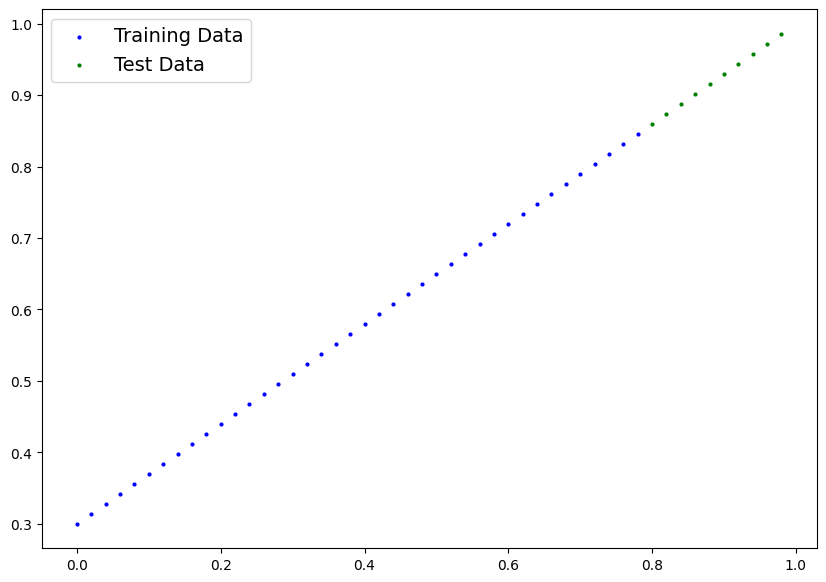

In [10]:
plot_predictions(X_train,y_train,X_test,y_test,None)

## 2. Build Model

In [14]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, dtype=torch.float),
                                requires_grad=True)

    self.bias = nn.Parameter(torch.randn(1, dtype=torch.float),
                              requires_grad=True)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
      return self.weights*x + self.bias

### Checking the contents of PyTorch model

In [15]:
torch.manual_seed(42)
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [16]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making Prediction using `torch.inference_mode()`

In [17]:
with torch.inference_mode():
  y_preds = model_0(X_test)

In [18]:
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


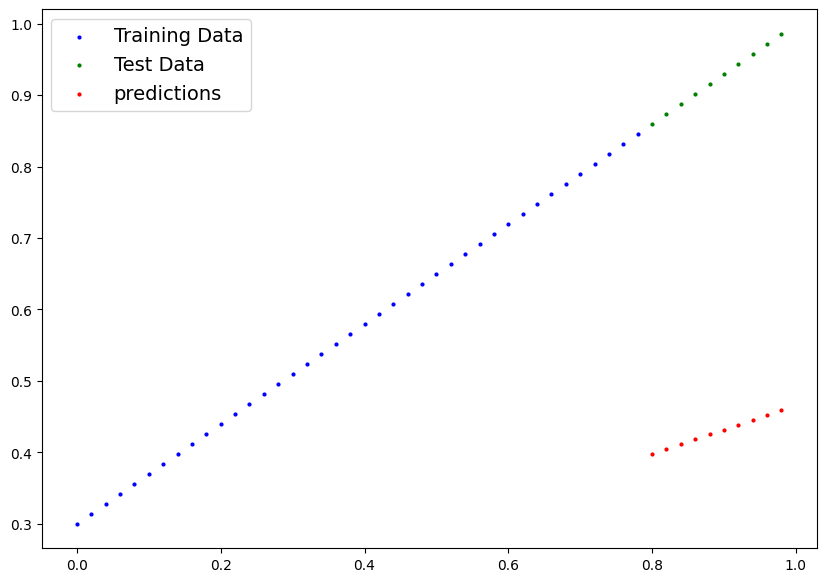

In [20]:
plot_predictions(X_train,y_train,X_test,y_test,y_preds)

In [21]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

Predictions are way off

## 3. Train Model

### Creating a loss function and optimizer

In [24]:
loss_fn = nn.L1Loss()         # MAE loss

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

### Pytorch Training loop

In [31]:
torch.manual_seed(123)

epochs = 1000

train_val_loss = []
test_val_loss = []
epoch_count = []

for epoch in range(epochs):

  # Training
  # Put model in training mode
  model_0.train()

  # 1. Forward pass on train data using the forward() method inside
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad of the optimizer
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Progress the optimizer
  optimizer.step()

  # Put model in evaluation mode
  model_0.eval()

  with torch.inference_mode():
    # 1. Forward pass on test data
    test_pred = model_0(X_test)

    # 2. Calculate loss on test data
    test_loss = loss_fn(test_pred, y_test.type(torch.float))

    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_val_loss.append(loss.detach().numpy())
      test_val_loss.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")


Epoch: 0 | MAE Train Loss: 0.024110013619065285 | MAE Test Loss: 0.05536102131009102 
Epoch: 10 | MAE Train Loss: 0.020677709951996803 | MAE Test Loss: 0.04777535796165466 
Epoch: 20 | MAE Train Loss: 0.017245199531316757 | MAE Test Loss: 0.0395028181374073 
Epoch: 30 | MAE Train Loss: 0.013806397095322609 | MAE Test Loss: 0.031230276450514793 
Epoch: 40 | MAE Train Loss: 0.010375778190791607 | MAE Test Loss: 0.023644620552659035 
Epoch: 50 | MAE Train Loss: 0.006941580679267645 | MAE Test Loss: 0.0153720797970891 
Epoch: 60 | MAE Train Loss: 0.0035027749836444855 | MAE Test Loss: 0.007099539041519165 
Epoch: 70 | MAE Train Loss: 0.0025885067880153656 | MAE Test Loss: 0.008447891101241112 
Epoch: 80 | MAE Train Loss: 0.0025885067880153656 | MAE Test Loss: 0.008447891101241112 
Epoch: 90 | MAE Train Loss: 0.0025885067880153656 | MAE Test Loss: 0.008447891101241112 
Epoch: 100 | MAE Train Loss: 0.0025885067880153656 | MAE Test Loss: 0.008447891101241112 
Epoch: 110 | MAE Train Loss: 0.00

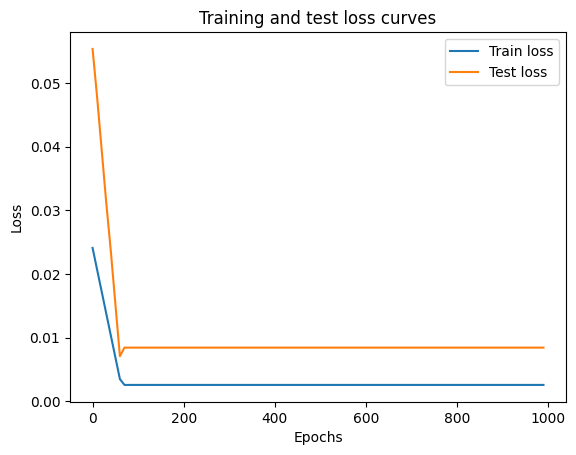

In [32]:
# Plot the Loss curves

plt.plot(epoch_count, train_val_loss, label="Train loss")
plt.plot(epoch_count, test_val_loss, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [33]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## 4. Making predictions with a trained PyTorch model

In [37]:
with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.8554],
        [0.8693],
        [0.8832],
        [0.8971],
        [0.9110],
        [0.9249],
        [0.9388],
        [0.9527],
        [0.9666],
        [0.9805]])

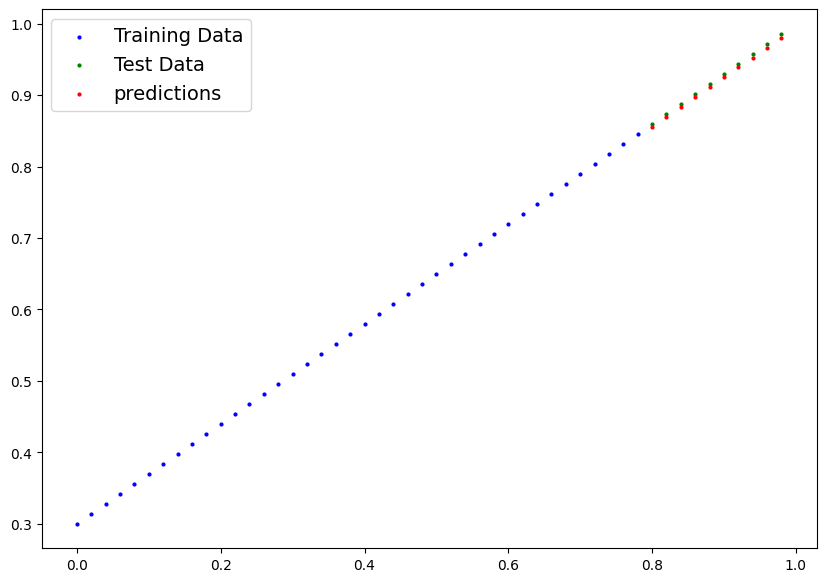

In [38]:
plot_predictions(X_train,y_train,X_test,y_test,y_preds)

## 5. Saving and loading a Pytorch model

In [39]:
from pathlib import Path

In [42]:
# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create Model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# 3. Save the model state_dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to : models/01_pytorch_workflow_model_0.pth


In [43]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1207 Aug 18 16:39 models/01_pytorch_workflow_model_0.pth


### Loading a Saved PyTOrch Model's `state_dict()`

In [46]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [48]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

In [49]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

In [50]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

In [51]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


### 6.1 Data

In [52]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [53]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

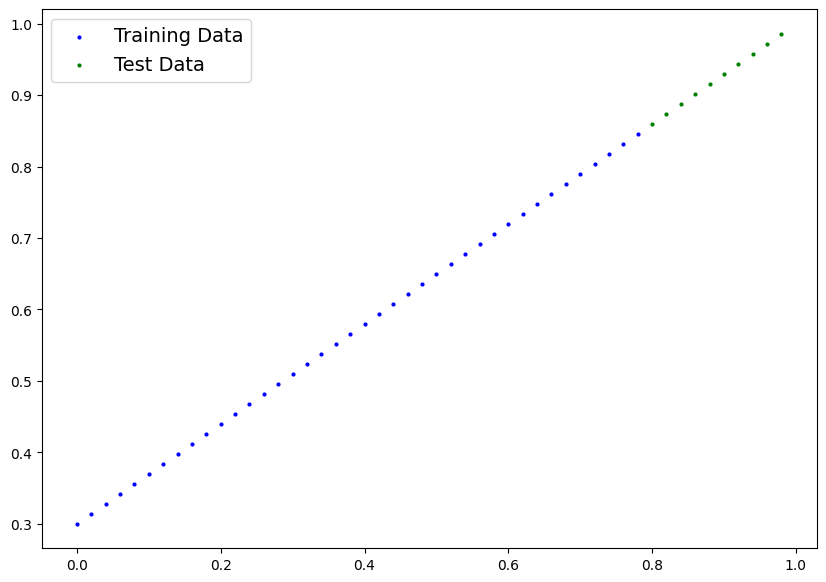

In [55]:
plot_predictions(X_train, y_train, X_test, y_test,None)

### 6.2 Building a PyTorch Linear Model

In [56]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [57]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [58]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cpu')

### 6.3 Training

In [59]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

In [60]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215679459273815 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904


In [61]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### 6.4 Making Predicitions

In [62]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

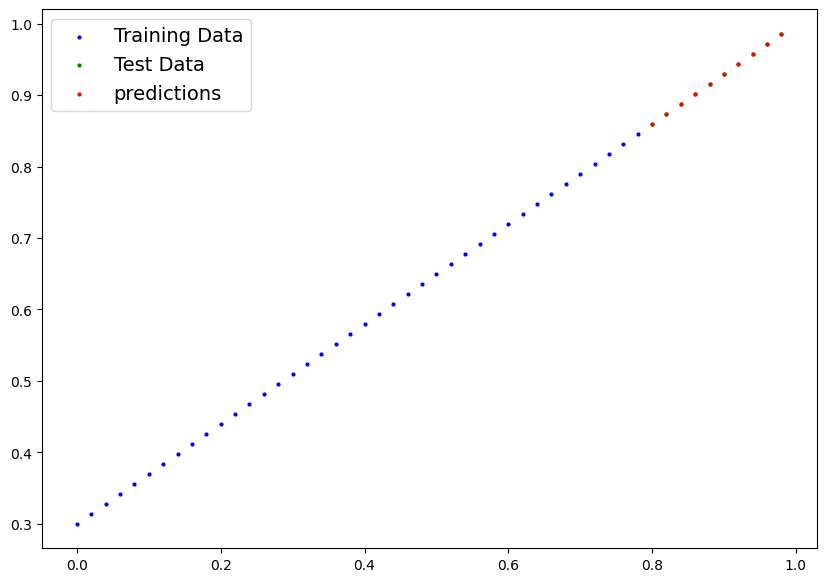

In [63]:
plot_predictions(X_train, y_train, X_test, y_test,predictions=y_preds.cpu())

### 6.5 Saving and Loading a Model

In [64]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [65]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cpu


In [66]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])